Reference

https://github.com/sweetcocoa/IKC

https://github.com/yuanjunchai/IKC

In [1]:
import os
import torch
from torchinfo import summary

In [2]:
# import module
from IKC.model.SFTMD import SFTMD
from IKC.model.Predictor import Predictor
from IKC.model.Corrector import Corrector

from utils.gaussian_kernel import make_and_save
from utils.dataset import get_datasets
from utils.dataloader import get_dataloader
from utils.plot_image import plot
from utils.utils import tensor2imgtensor

from IKC.codes.train_sftmd import train_sftmd
from IKC.codes.train_ikc import train_IKC
from IKC.codes.test import test

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

1.13.0+cu116
True


hyperparameters

In [4]:
args = dict(
    train = './data/train/',
    valid = './data/valid/',
    test = './data/test/Set5',
    kernel_path = './IKC',
    kernel_num = 10000,
    reduced_kernel_dim = 10,
    scale = 4,
    batch_size = 16,
    lr = 1e-4,
    beta1 = 0.9,
    beta2 = 0.99,
    step_size = 10,
    gamma = 0.9,
    num_epoch_sftmd = 50,
    num_epoch_IKC = 50,
    num_iter = 7,
    device = device,
    log_interval = 50,
    ckpt_dir = './IKC/checkpoints',
    result_dir = './IKC/results',
    sftmd_train = False,
    IKC_train = False,
)

Make Gausian Kernels and Save Kernels

In [5]:
make_and_save(args)

creating kernel dict is complete


Load Datasets

In [6]:
train_ds, valid_ds, test_ds = get_datasets(args)

In [7]:
train_dl = get_dataloader(train_ds, args['batch_size'], shuffle=True)
valid_dl = get_dataloader(valid_ds, args['batch_size'], shuffle=False)
test_dl = get_dataloader(test_ds, 1, shuffle=False)

HR image shape:		 torch.Size([3, 144, 144])
LR image shape:		 torch.Size([3, 36, 36])
kernel shape:		 (21, 21)
reduced kernel shape:	 (10,)
num of train image:	 3450


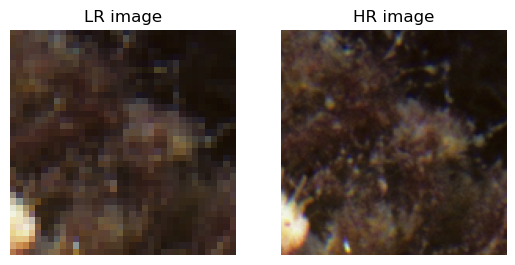

In [8]:
print('HR image shape:\t\t', train_ds[0]['HR'].shape)
print('LR image shape:\t\t', train_ds[0]['LR'].shape)
print('kernel shape:\t\t', train_ds[0]['kernel'].shape)
print('reduced kernel shape:\t', train_ds[0]['reduced_kernel'].shape)
print('num of train image:\t', len(train_ds))

img1 = train_ds[0]
HR, LR = img1['HR'], img1['LR']
plot([tensor2imgtensor(LR), tensor2imgtensor(HR)], ['LR image', 'HR image'], (1, 2))

Model Info

In [9]:
sftmd = SFTMD(3, args['reduced_kernel_dim'], 64, 16, args['scale'])

dummy_LR = (args['batch_size'], 3, 144 // args['scale'], 144 // args['scale'])
dummy_kernel = (args['batch_size'], args['reduced_kernel_dim'])

print(summary(sftmd, [dummy_LR, dummy_kernel]))

Layer (type:depth-idx)                   Output Shape              Param #
SFTMD                                    [16, 3, 144, 144]         --
├─Sequential: 1-1                        [16, 64, 36, 36]          --
│    └─Conv2d: 2-1                       [16, 64, 36, 36]          1,792
│    └─LeakyReLU: 2-2                    [16, 64, 36, 36]          --
├─Sequential: 1-2                        [16, 64, 36, 36]          --
│    └─Conv2d: 2-3                       [16, 64, 36, 36]          36,928
│    └─LeakyReLU: 2-4                    [16, 64, 36, 36]          --
├─Sequential: 1-3                        [16, 64, 36, 36]          --
│    └─Conv2d: 2-5                       [16, 32, 36, 36]          21,344
│    └─LeakyReLU: 2-6                    [16, 32, 36, 36]          --
│    └─Conv2d: 2-7                       [16, 64, 36, 36]          18,496
├─Sigmoid: 1-4                           [16, 64, 36, 36]          --
├─Sequential: 1-5                        [16, 64, 36, 36]          --


In [10]:
predictor = Predictor(3, args['reduced_kernel_dim'], 64)

print(summary(predictor, dummy_LR))

Layer (type:depth-idx)                   Output Shape              Param #
Predictor                                [16, 10]                  --
├─Sequential: 1-1                        [16, 64, 36, 36]          --
│    └─Conv2d: 2-1                       [16, 64, 36, 36]          4,864
│    └─LeakyReLU: 2-2                    [16, 64, 36, 36]          --
├─Sequential: 1-2                        [16, 64, 36, 36]          --
│    └─Conv2d: 2-3                       [16, 64, 36, 36]          102,464
│    └─LeakyReLU: 2-4                    [16, 64, 36, 36]          --
├─Sequential: 1-3                        [16, 64, 36, 36]          --
│    └─Conv2d: 2-5                       [16, 64, 36, 36]          102,464
│    └─LeakyReLU: 2-6                    [16, 64, 36, 36]          --
├─Sequential: 1-4                        [16, 10, 36, 36]          --
│    └─Conv2d: 2-7                       [16, 10, 36, 36]          16,010
│    └─LeakyReLU: 2-8                    [16, 10, 36, 36]          -

In [11]:
corrector = Corrector(3, args['reduced_kernel_dim'], 64)

dummy_SR = (args['batch_size'], 3, 144, 144)

print(summary(corrector, [dummy_SR, dummy_kernel]))

Layer (type:depth-idx)                   Output Shape              Param #
Corrector                                [16, 10]                  --
├─Sequential: 1-1                        [16, 64, 144, 144]        --
│    └─Conv2d: 2-1                       [16, 64, 144, 144]        4,864
│    └─LeakyReLU: 2-2                    [16, 64, 144, 144]        --
├─Sequential: 1-2                        [16, 64, 72, 72]          --
│    └─Conv2d: 2-3                       [16, 64, 72, 72]          102,464
│    └─LeakyReLU: 2-4                    [16, 64, 72, 72]          --
├─Sequential: 1-3                        [16, 64, 72, 72]          --
│    └─Conv2d: 2-5                       [16, 64, 72, 72]          102,464
│    └─LeakyReLU: 2-6                    [16, 64, 72, 72]          --
├─Sequential: 1-4                        [16, 64, 36, 36]          --
│    └─Conv2d: 2-7                       [16, 64, 36, 36]          102,464
│    └─LeakyReLU: 2-8                    [16, 64, 36, 36]          

Train SFTMD

In [12]:
if args['sftmd_train']:
    print("train sftmd start")
    train_sftmd(train_dl, valid_dl, len(train_ds), sftmd, args)
    print("train sftmd end")

ckpt_path = os.path.join(args['ckpt_dir'], f"ckpt_sftmd_x{args['scale']}.pth")
sftmd.load_state_dict(torch.load(ckpt_path)['model_state_dict'])
print("load sftmd:", ckpt_path)

load sftmd: ./IKC/checkpoints\ckpt_sftmd_x4.pth


Train Predictor and Corrector

In [13]:
if args['IKC_train']:
    print("train predictor and corrector start")
    train_IKC(train_dl, valid_dl, len(train_ds), sftmd, predictor, corrector, args)
    print("train predictor and corrector end")
    
ckpt_path_p = os.path.join(args['ckpt_dir'], f"ckpt_predictor_x{args['scale']}.pth")
ckpt_path_c = os.path.join(args['ckpt_dir'], f"ckpt_corrector_x{args['scale']}.pth")
predictor.load_state_dict(torch.load(ckpt_path_p)['model_state_dict'])
corrector.load_state_dict(torch.load(ckpt_path_c)['model_state_dict'])
print("load predictor:", ckpt_path_p)
print("load corrector:", ckpt_path_c)

load predictor: ./IKC/checkpoints\ckpt_predictor_x4.pth
load corrector: ./IKC/checkpoints\ckpt_corrector_x4.pth


Inference model

Fri Apr 21 15:46:55 2023	[1/5]	test [mse: 0.00090  ssim: 0.85972  psnr: 30.47647]


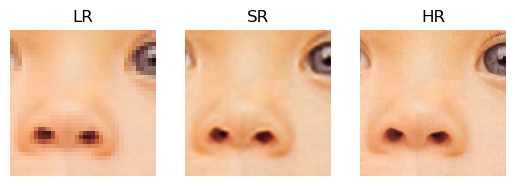

Fri Apr 21 15:46:55 2023	[2/5]	test [mse: 0.00161  ssim: 0.83143  psnr: 27.92009]


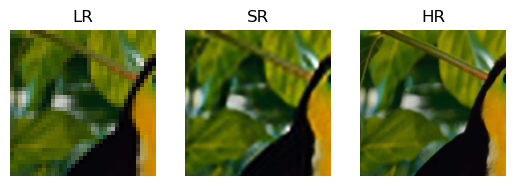

Fri Apr 21 15:46:55 2023	[3/5]	test [mse: 0.00574  ssim: 0.76499  psnr: 22.36286]


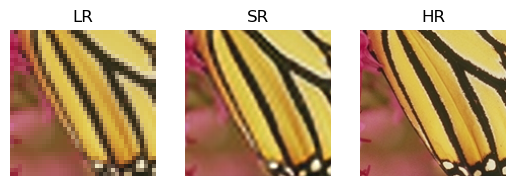

Fri Apr 21 15:46:56 2023	[4/5]	test [mse: 0.00127  ssim: 0.71139  psnr: 28.93104]


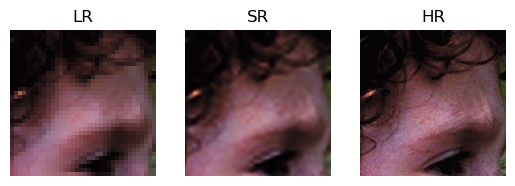

Fri Apr 21 15:46:56 2023	[5/5]	test [mse: 0.00240  ssim: 0.85178  psnr: 26.18890]


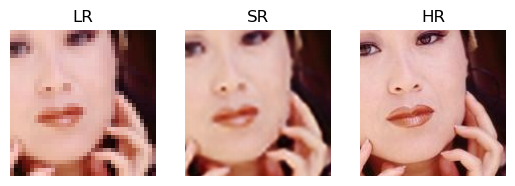

avg mse: 0.00238
avg ssim: 0.80386
avg psnr: 27.17587
total time: 2.11681 sec


In [14]:
test(test_dl, len(test_ds), sftmd, predictor, corrector, args)